In [1]:
import tensorflow as tf
import numpy as np
import os.path
import joblib
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPool2D, Add, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import os
import shutil
import random
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Imported the neccessary libraries 

2023-05-23 15:03:56.018566: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 15:03:56.352233: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-23 15:03:56.385006: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-23 15:03:56.385028: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
import os
import shutil
import glob
import random

def copy_files_70_30_percent():
    os.chdir(os.path.dirname(os.path.abspath('model_alzheimers_cnn.ipynb')))
    
    if os.path.isdir('model_data') is False:
        os.makedirs('model_data/train/axial/AD')
        os.makedirs('model_data/train/coronal/AD')
        os.makedirs('model_data/train/sagittal/AD')
        os.makedirs('model_data/train/axial/CN')
        os.makedirs('model_data/train/coronal/CN')
        os.makedirs('model_data/train/sagittal/CN')
        os.makedirs('model_data/train/axial/MCI')
        os.makedirs('model_data/train/coronal/MCI')
        os.makedirs('model_data/train/sagittal/MCI')
        os.makedirs('model_data/valid/axial/AD')
        os.makedirs('model_data/valid/coronal/AD')
        os.makedirs('model_data/valid/sagittal/AD')
        os.makedirs('model_data/valid/axial/CN')
        os.makedirs('model_data/valid/coronal/CN')
        os.makedirs('model_data/valid/sagittal/CN')
        os.makedirs('model_data/valid/axial/MCI')
        os.makedirs('model_data/valid/coronal/MCI')
        os.makedirs('model_data/valid/sagittal/MCI')
        
        # get current directory
        print(os.getcwd())
        for view in ['axial', 'coronal', 'sagittal']:
            # os.chdir('../')
            all_ad_files = glob.glob(f'Processed_MRI/augmented/AD/{view}/*')
            all_cn_files = glob.glob(f'Processed_MRI/augmented/CN/{view}/*')
            all_mci_files = glob.glob(f'Processed_MRI/augmented/MCI/{view}/*')
            
            print(len(all_ad_files))

            num_ad_files = len(all_ad_files)
            num_cn_files = len(all_cn_files)
            num_mci_files = len(all_mci_files)

            num_ad_train = int(0.7 * num_ad_files)
            num_cn_train = int(0.7 * num_cn_files)
            num_mci_train = int(0.7 * num_mci_files)

            ad_train_files = random.sample(all_ad_files, num_ad_train)
            cn_train_files = random.sample(all_cn_files, num_cn_train)
            mci_train_files = random.sample(all_mci_files, num_mci_train)

            ad_valid_files = list(set(all_ad_files) - set(ad_train_files))
            cn_valid_files = list(set(all_cn_files) - set(cn_train_files))
            mci_valid_files = list(set(all_mci_files) - set(mci_train_files))

            # print(os.getcwd())
            # os.chdir('code')
            for c in ad_train_files:
                shutil.copy(c, f'model_data/train/{view}/AD')
            for c in cn_train_files:
                shutil.copy(c, f'model_data/train/{view}/CN')
            for c in mci_train_files:
                shutil.copy(c, f'model_data/train/{view}/MCI')

            for c in ad_valid_files:
                shutil.copy(c, f'model_data/valid/{view}/AD')
            for c in cn_valid_files:
                shutil.copy(c, f'model_data/valid/{view}/CN')
            for c in mci_valid_files:
                shutil.copy(c, f'model_data/valid/{view}/MCI')


In [3]:
copy_files_70_30_percent()

#split the dataset into training and validation sets with a 70/30 percent split

In [4]:
train_path = 'model_data/train/axial' 
valid_path = 'model_data/valid/axial'

#assigns file paths to train_path and valid_path to the respective directories 

## Use the vgg16 prepocesser to preprocess the images which resizes and reshapes the images to feed the model

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224, 224), batch_size=10, classes=['AD', 'CN'])
 
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224, 224), batch_size=10, classes=['AD', 'CN'], shuffle=False)

Found 695 images belonging to 2 classes.
Found 299 images belonging to 2 classes.


In [6]:
# assert train_batches.n == 1341
# assert valid_batches.n == 576

In [7]:
imgs, labels = next(train_batches) # Here labels shows which class is positive. 

In [8]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show() 
    
#displays an array of the images in a 10x1 grid with no axis labels.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

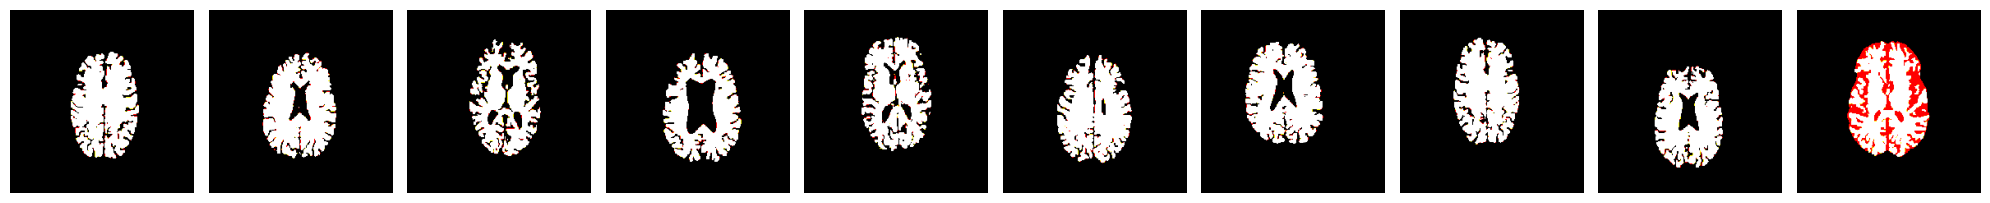

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [9]:
plotImages(imgs)
print(labels)

## Filters

The higher the number of filters, the higher the number of abstractions that your Network is able to extract from image data. The reason why the number of filters is generally ascending is that at the input layer the Network receives raw pixel data. Raw data are always noisy, and this is especially true for image data.

Because of this, we let CNNs extract first some relevant information from noisy, "dirty" raw pixel data. Once the useful features have been extracted, then we make the CNN elaborate more complex abstractions on it.

That is why the number of filters usually increases as the Network gets deeper, even though it doesn't necessarily have to be like that.


## Kernel Size

Convolutional neural networks work on 2 assumptions -

Low level features are local
What's useful in one place will also be useful in other places
Kernel size should be determined by how strongly we believe in those assumptions for the problem at hand.

In one extreme case where we have 1x1 kernels, we are essentially saying low level features are per-pixel, and they don't affect neighbouring pixels at all, and that we should apply the same operation to all pixels.

In the other extreme, we have kernels the size of the entire image. In this case the CNN essentially becomes fully connected, and stops being a CNN, and we are no longer making any assumption on low level feature locality.

In [10]:

from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model


def residual_block(inputs, num_filters):
    x = Conv2D(filters=num_filters, kernel_size=(3,3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=num_filters, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    if inputs.shape[-1] != num_filters:
        shortcut = Conv2D(num_filters, (1, 1), padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = inputs
    x = Add()([x, shortcut]) #The Add() layer creates skip connections that help to mitigate the vanishing gradient problem and improve the training and convergence of the model
    x = Activation('relu')(x)
    return x

input_tensor = Input(shape=(224, 224, 3))
x = Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(input_tensor)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)
x = residual_block(x, num_filters=32)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)
x = residual_block(x, num_filters=64)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)
x = residual_block(x, num_filters=128)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)
x = residual_block(x, num_filters=256)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)
x = residual_block(x, num_filters=512)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)
x = Flatten()(x)
x = Dense(units=256, activation='relu')(x)
x = Dropout(0.25)(x)
output_tensor = Dense(units=2, activation='softmax')(x)

#softmax used here for the classification problems to produce a probability distribution over the possible classes. 
#it ensures the predicted probabilities sum up to 1, which is required for a probability distribution.

model = Model(inputs=input_tensor, outputs=output_tensor)

#The Add() layer is used to add the input tensor (shortcut) to the output of the block (x), which creates a skip connection.
#thus helping to mitigate the vanishing gradient problem that can occur in deep neural networks.
#The skip connections created by the Add() layer allow the gradients to propagate through the network 
# and can help to improve the training and convergence of the model.

2023-05-23 15:04:07.313825: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-23 15:04:07.313875: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (divya-Inspiron-15-5518): /proc/driver/nvidia/version does not exist
2023-05-23 15:04:07.315175: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


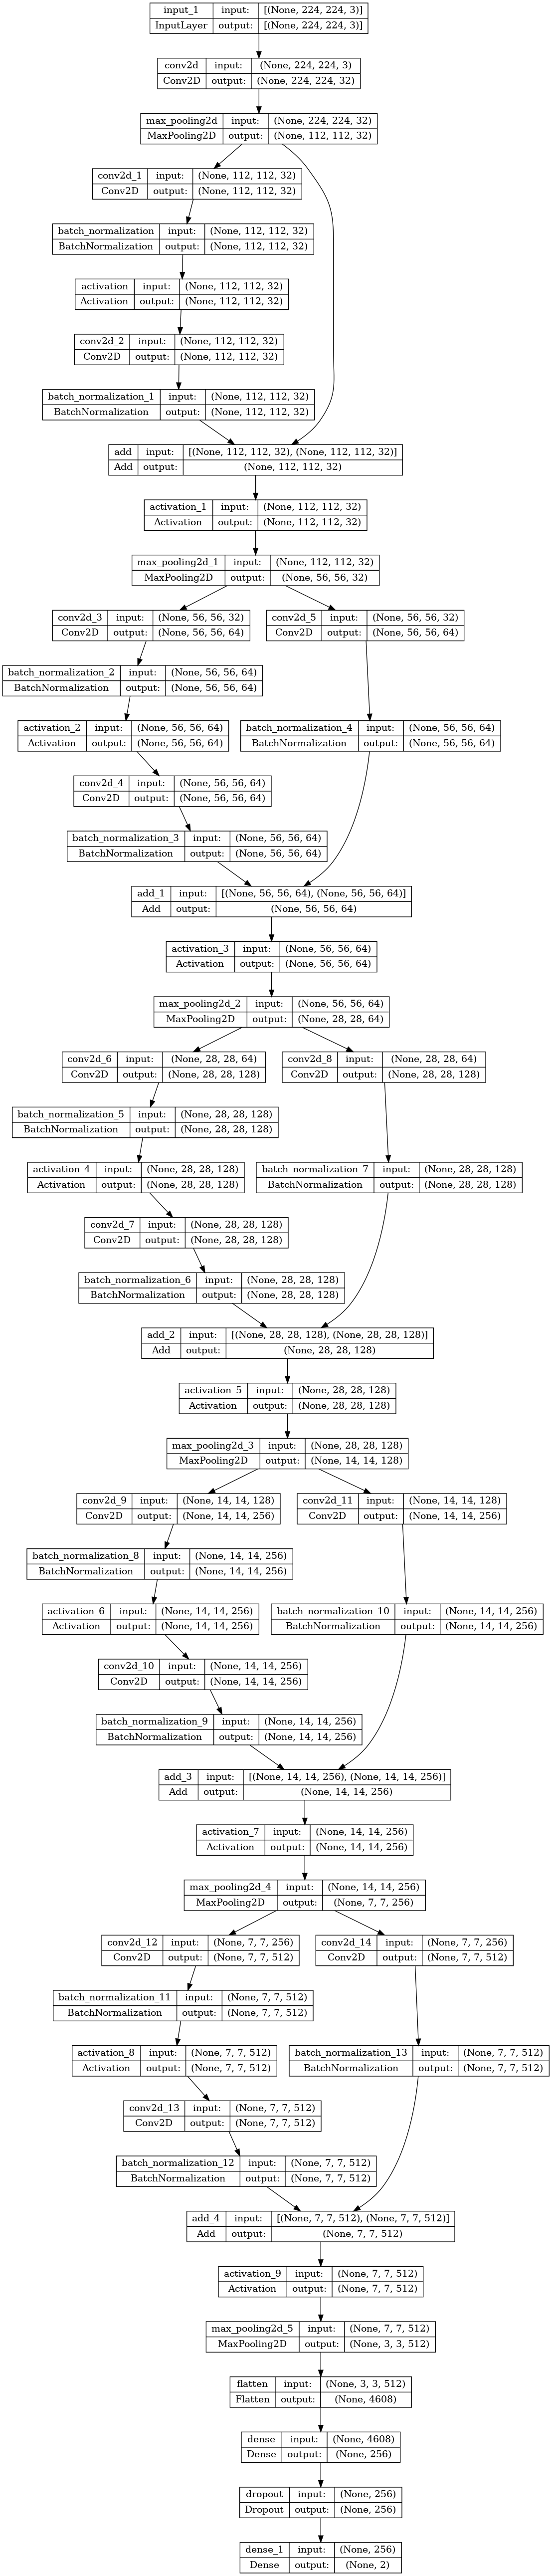

In [11]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot_binary.png', show_shapes=True, show_layer_names=True)

#get the output for the architecture 

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 112, 112, 32  0           ['conv2d[0][0]']                 
                                )                                                             

In [13]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

#using the Adam optimizer with a learning rate of 0.0001, categorical cross-entropy as the loss function, and accuracy as the metric to be monitored during training.

In [14]:
from keras.callbacks import LearningRateScheduler

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True)


def lr_schedule(epoch):
    lr = 0.0001
    if epoch > 20:
        lr *= 0.1
    return lr

##The learning rate scheduler adjusts the learning rate of the Adam optimizer based on the epoch number, reducing it by a factor of 10 after 20 epochs. 


if os.path.isfile('models/simple_model.h5'):
    model = load_model('models/simple_model.h5')
    history = joblib.load('models/history/simple_model_history.pkl')
else:
    history = model.fit(x=train_batches, validation_data=valid_batches, epochs=50, verbose=2, callbacks=[callback, LearningRateScheduler(lr_schedule)])
    joblib.dump(history, 'models/history/simple_model_history.pkl')
    
    model.save('models/simple_model.h5')
    
#the model is trained for 50 epochs on the training and validation data, 
# with the early stopping and learning rate scheduler callbacks applied, and the model and history are saved to the file system.    

Keras model archive loading:
File Name                                             Modified             Size
variables.h5                                   2023-03-10 01:03:48     73210304
metadata.json                                  2023-03-10 01:03:48           64
config.json                                    2023-03-10 01:03:48        25779
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......activation_4
.........vars
......activation_5
.........vars
......activation_6
.........vars
......activation_7
.........vars
......activation_8
.........vars
......activation_9
.........vars
......add
.........vars
......add_1
.........vars
......add_2
.........vars
......add_3
.........vars
......add_4
.........vars
......batch_normalization
.........vars
............0
............1
............2
............3
......batch_normalizati

# Tracking Convergence

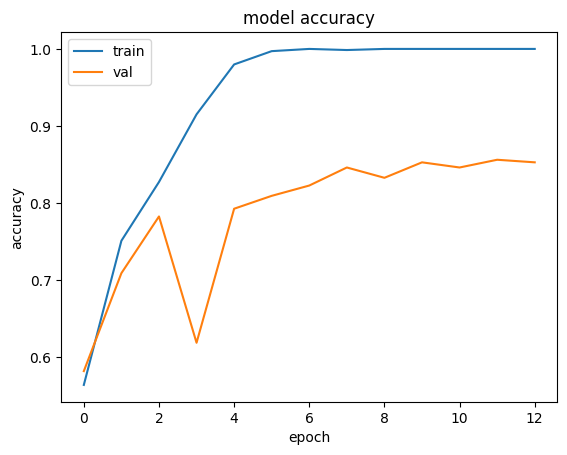

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#plots the accuracy of the model over epochs on both training and validation data. 
#It helps visualizing the performance of the model and identify overfitting or underfitting

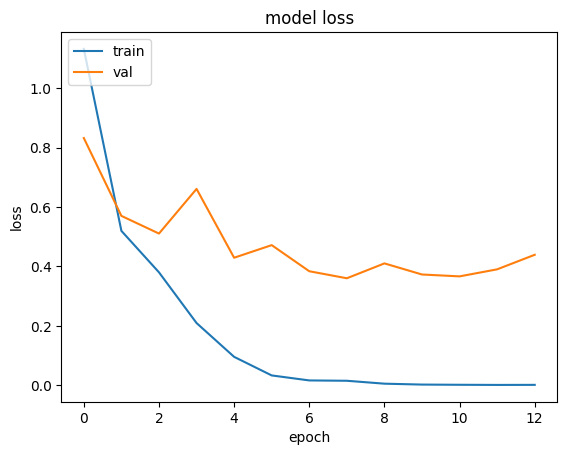

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#plots the training and validation loss of the machine learning model over epochs to visualize overfitting or underfitting.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

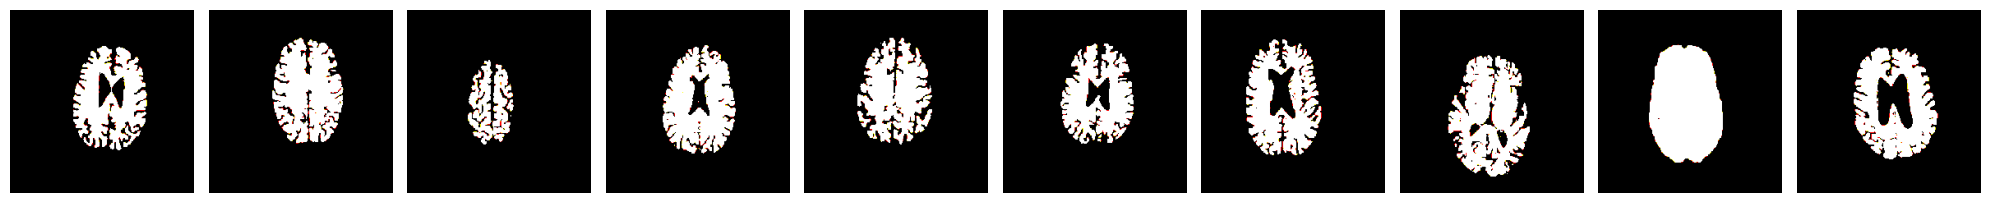

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [17]:
test_imgs, test_labels = next(valid_batches)
plotImages(test_imgs)
print(test_labels)

#inspect a set of test images along with their associated labels

In [18]:
predictions = model.predict(x=valid_batches, verbose=0)

#generate predictions on a set of data represented by valid_batches, and stores the resulting predictions in predictions for further evaluation

In [19]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

In [20]:
test_imgs, test_labels = next(valid_batches)

In [21]:
test_labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [22]:
import os
from tensorflow.keras.preprocessing.image import load_img

# Get the list of file names in the directory
file_names_ad = os.listdir(train_path + "/AD")

# Select the first file name from the list
first_file_name = file_names_ad[0]

# Load the first image
ad = load_img(train_path + "/AD/" + first_file_name)

# Get the list of file names in the directory
file_names_cn = os.listdir(train_path + "/CN")

# Select the first file name from the list
first_file_name = file_names_cn[0]

# Load the first image
cn = load_img(train_path + "/CN/" + first_file_name)


In [23]:
# Preprocess the images using VGG16 preprocessing function
ad_processed = tf.keras.applications.vgg16.preprocess_input(np.array(ad.resize((224, 224))))
cn_processed = tf.keras.applications.vgg16.preprocess_input(np.array(cn.resize((224, 224))))

# Create a batch of size 2 with the processed images
visualize_batch = np.stack([ad_processed, cn_processed])


In [24]:
visualize_batch[0].shape

(224, 224, 3)

In [25]:
len(model.layers)

55

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


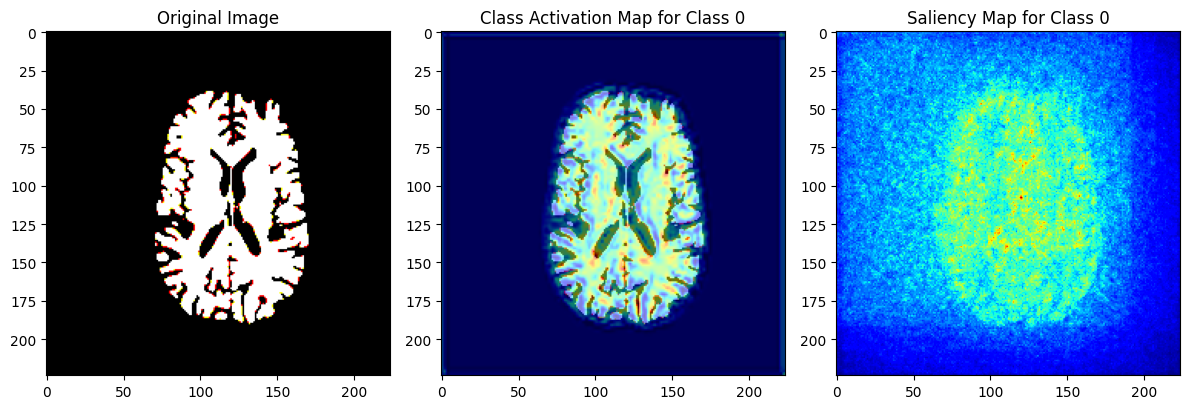

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


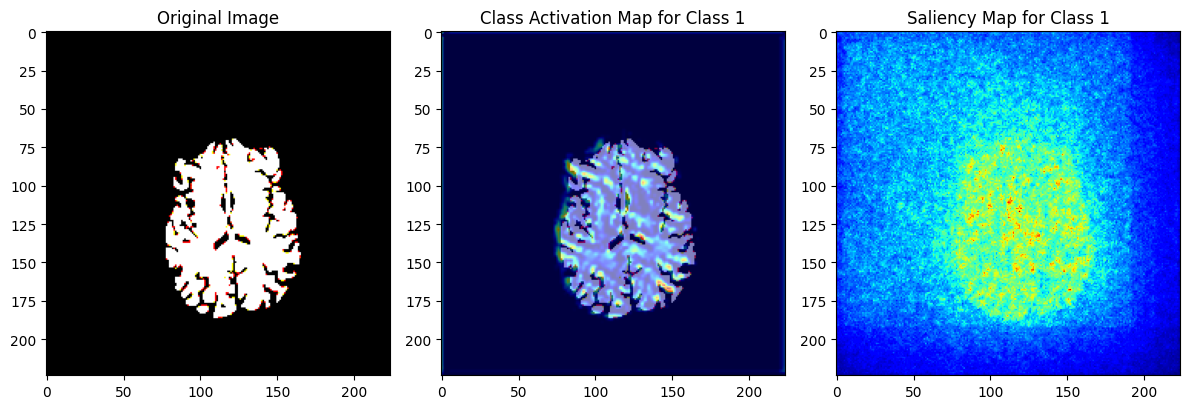

In [26]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam  #CAMs  highlight which parts of the image contributed most to the predicted class
from tf_keras_vis.saliency import Saliency
replace2linear = ReplaceToLinear()  # This is used to replace all activation functions in the model with linear activations.

# Select an image from the validation set

#Here we have used tensorflow keras visualisation library to generate heatmaps (Heat Maps are graphical representations of data that utilize color-coded systems) 
# of class activation maps (CAMs) and saliency maps for an image classification model
# Select an image from the validation set

batch = valid_batches
# gradcam_model = tf.keras.models.Model(
#     [model.inputs], [model.layers[-3].output, model.output]
# )
# Create GradCAM++ object  #GradCAM++ is an extension of GradCAM that improves the visualization quality of GradCAM.
# Create Gradcam object
gradcam = GradcamPlusPlus(model,
                  model_modifier=replace2linear,
                  
                  clone=True)

# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map (saliency maps highlight which pixels contributed most to the prediction.)


# Loop over all classes and generate corresponding heatmaps
for class_index in range(len(valid_batches.class_indices)):
    # error = True
    # image_index = np.where(visualize_batch.classes == class_index)[0][0]
    image = visualize_batch[class_index]
    # Generate cam with GradCAM++
    cam = gradcam(CategoricalScore(class_index), image, penultimate_layer=10)
    saliency_map = saliency(CategoricalScore(class_index), image, smooth_samples=20, smooth_noise=0.20) # noise spread level.)
    
    # Plot the original image and the heatmap
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    axs[0].imshow(image)
    axs[0].set_title('Original Image')
    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
    axs[1].imshow(image)
    axs[1].imshow(heatmap, alpha=0.5, cmap='jet')
    axs[1].set_title(f'Class Activation Map for Class {class_index}')
    
    axs[2].imshow(saliency_map[0], cmap='jet')
    axs[2].set_title(f'Saliency Map for Class {class_index}')
    plt.tight_layout()
    plt.show()

#visualize which parts of an image the model is paying attention to when making its predictions. 
# It does so by generating heatmaps of the CAMs and saliency maps. 


In [27]:
cm = confusion_matrix(y_true=valid_batches.classes, y_pred=np.argmax(predictions, axis=1))

# calculates the confusion matrix for a classification problem, using the true class labels from valid_batches.classes 
# and predicted class labels from predictions using np.argmax().

In [28]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
    #This function prints and plots the confusion matrix.
   # Normalization can be applied by setting `normalize=True`.
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}%".format(cm[i, j] * 100),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [29]:
valid_batches.class_indices

{'AD': 0, 'CN': 1}

Confusion matrix for the model is shown below, where the diagonal elements are the true positives, the off-diagonal elements are the false positives.

Normalized confusion matrix
[[0.84       0.16      ]
 [0.14942529 0.85057471]]


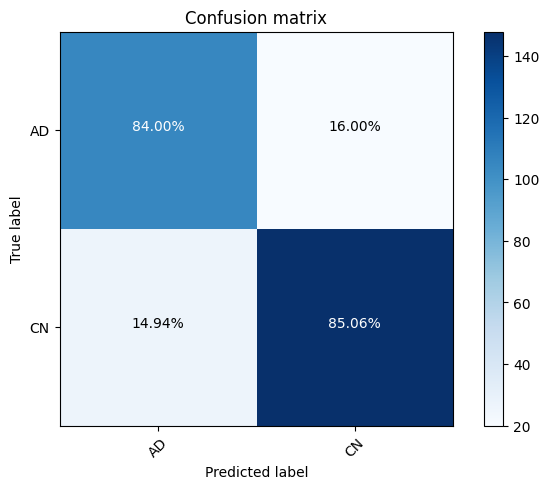

In [30]:
cm_plot_labels = valid_batches.class_indices.keys()
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion matrix', normalize= True)

In [31]:
from sklearn import metrics

print(metrics.classification_report(valid_batches.classes, np.argmax(predictions, axis=-1), target_names=cm_plot_labels))

#Generate the report that includes precision, recall, F1 score, and support metrics for the binary class 

              precision    recall  f1-score   support

          AD       0.80      0.84      0.82       125
          CN       0.88      0.85      0.87       174

    accuracy                           0.85       299
   macro avg       0.84      0.85      0.84       299
weighted avg       0.85      0.85      0.85       299

